In [231]:
import numpy as np
import os
import glob
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import h5py as h5

In [232]:
files = glob.glob(f"./SampleData/stream2/ScoutingAnalyserResults/run_393448*")
unique_luminosity = set([])

In [233]:
def read_sparse(data, nbins):
    dense = np.zeros(nbins)
    for idx, val in data.items():
        dense[int(idx)] = val
    return dense

In [234]:
data_dict = {}

### Merging the files with same lumi
for file in tqdm(files):
    file = open(file,"r")
    file_data = file.readlines()
    file.close()
    meta_data = json.loads(file_data[1])
    data = json.loads(file_data[0])
    lumi = float(meta_data["luminosity_blocks"])
    
    UBIN = data["bins"][1]
    LBIN = data["bins"][0]
    BINW = data["bins"][2]
    NBIN = (UBIN-LBIN)//BINW

    data_dict[lumi] = read_sparse(data["counts"],NBIN)[None,:]
    

  0%|          | 0/445 [00:00<?, ?it/s]

In [235]:
unique_ls = list(data_dict.keys())
unique_ls.sort()

unique_ls = np.array(unique_ls)
unique_ls = unique_ls[unique_ls < 400]

freq_list = []

for ls in tqdm(unique_ls):
    freq_list.append(data_dict[ls])

  0%|          | 0/369 [00:00<?, ?it/s]

In [236]:
progression = np.concatenate(freq_list,0)

collapse_order = 1 ## Order by which one needs to collapse the bins
progression = progression.reshape(progression.shape[0], -1, collapse_order).sum(axis=2)

safe_progression = np.where(progression > 0, progression, 1e-9)
log_prog = np.log10(safe_progression)
# log_prog[log_prog < 0] = 0
binning = np.arange(LBIN,UBIN,BINW*collapse_order)

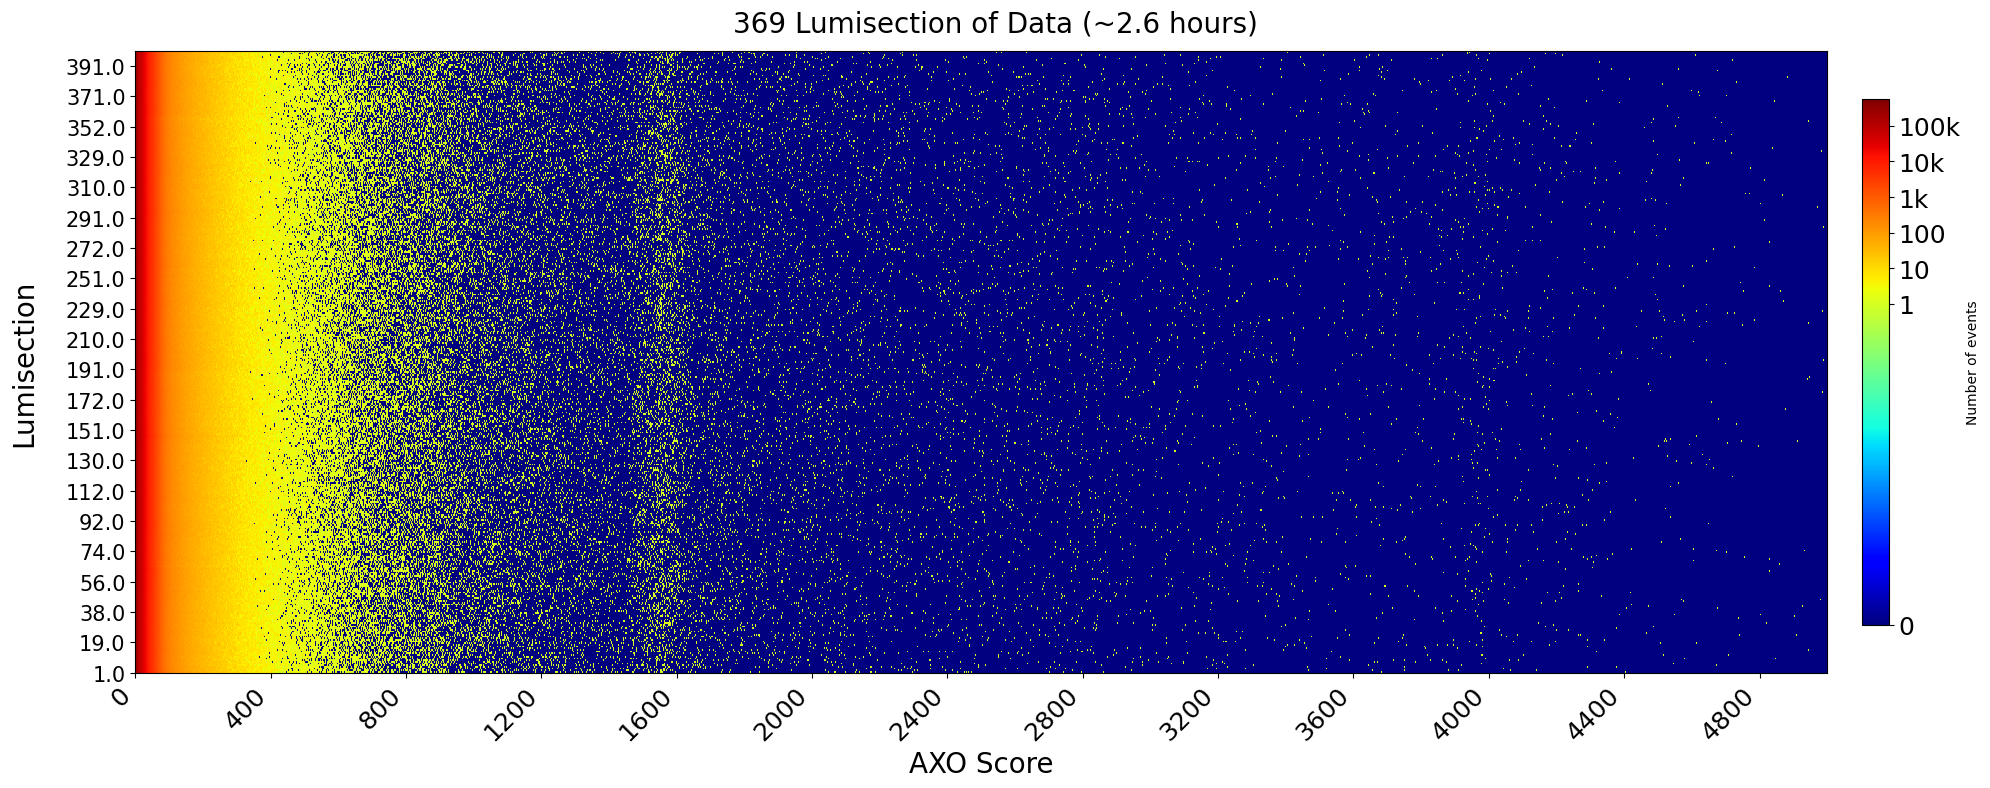

In [237]:

nrows, ncols = log_prog.shape
xtick_step = max(ncols // 50, 1)
ytick_step = max(nrows // 20, 1)

xtick_idx = np.arange(0, ncols, xtick_step)
ytick_idx = np.arange(0, nrows, ytick_step)

xlabels = [binning[i] if i < len(binning) else '' for i in xtick_idx]
ylabels = [unique_ls[i] if i < len(unique_ls) else '' for i in ytick_idx]

fig, ax = plt.subplots(figsize=(20, 8))

mesh = ax.pcolormesh(log_prog, cmap='jet', shading='auto')
ax.set_aspect('auto')

ax.set_xticks(xtick_idx)
ax.set_xticklabels(xlabels, rotation=45, ha='right', fontsize=18)
ax.set_yticks(ytick_idx)
ax.set_yticklabels(ylabels, fontsize=15)

ax.set_xlabel("AXO Score", fontsize=20)
ax.set_ylabel("Lumisection", fontsize=20, labelpad=20)

cbar = fig.colorbar(mesh, ax=ax, fraction=0.015, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks([-9,0,1,2,3,4,5])
cbar.set_ticklabels(['0','1', '10', '100', '1k','10k','100k'])
cbar.set_label('Number of events')

plt.xlim(0,5000)
plt.suptitle(f"{safe_progression.shape[0]} Lumisection of Data (~2.6 hours)",fontsize=20)
plt.tight_layout()
plt.show()

In [238]:
progression = np.concatenate(freq_list,0)

collapse_order = 10 ## Order by which one needs to collapse the bins
progression = progression.reshape(progression.shape[0], -1, collapse_order).sum(axis=2)
binning = np.arange(LBIN,UBIN,BINW*collapse_order)

In [239]:
bc_rate_khz = 2448*11.2456
raw_thres = 1000

projected_raw_rates = []

for ls in unique_ls:
    data = data_dict[ls]
    all_bin = np.arange(LBIN,UBIN,BINW)

    closest_idx = np.argmin((all_bin - raw_thres)**2)
    projected_raw_rates.append((np.sum(data[0,closest_idx:])/np.sum(data))*bc_rate_khz)

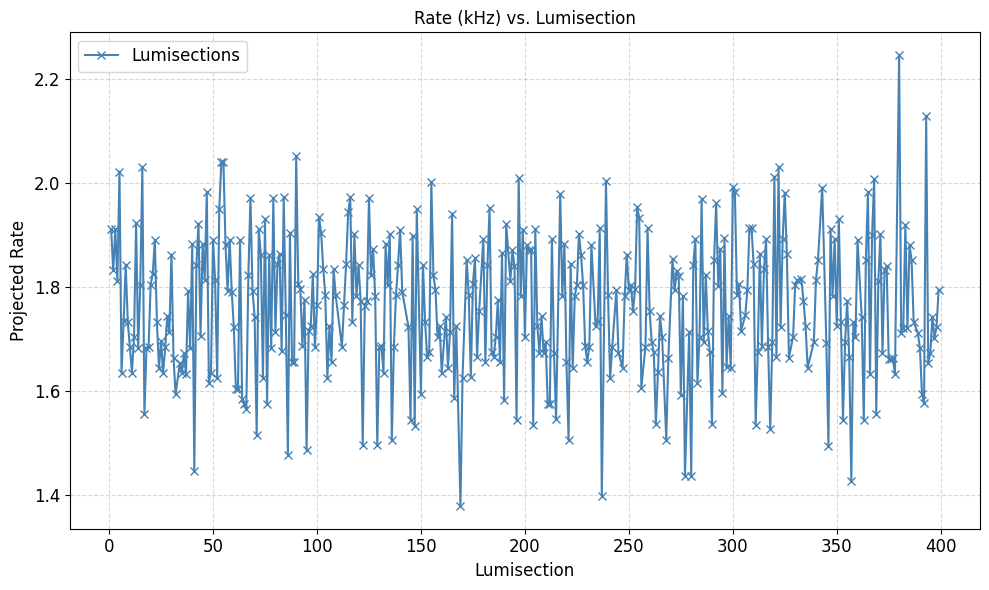

In [240]:

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(unique_ls, projected_raw_rates, linestyle='-', marker='x', color='steelblue', label="Lumisections")


# Labels, title, grid
ax.set_xlabel("Lumisection", fontsize=12)
ax.set_ylabel("Projected Rate", fontsize=12)
ax.set_title("Rate (kHz) vs. Lumisection", fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
ax.tick_params(labelsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()